In [85]:
# Mahir Mehta and Isaiah Sinclair's FIN*4100 Term Project Code

# Importing Libraries
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import numpy as np
import statsmodels.regression.recursive_ls as rls
import datetime
import statsmodels.stats.diagnostic as dg

In [86]:
# Getting Data, note date format is in 'YYYY-MM-DD'
prices = yf.download("XIU.TO", start="1999-12-01", end="2024-01-31", interval="1mo")

# Creating a Normal Index Column and a DataFrame
prices.reset_index(inplace=True)

# Dates say the first day of the month, but that should be ignored -- it is reflecting the end of the month when it is calculating the price change
# This is just an issue with downloading monthly data from Yahoo finance
prices = pd.DataFrame({'date': prices['Date'], 'monthlyPrice': prices['Adj Close']})

# Obtaining percentage changes, dropping top row since it does not have a percentage change
prices['monthlyReturn'] = prices['monthlyPrice'].pct_change() * 100
prices = prices.drop(0)

# Dropping monthly price since it is not needed
prices.drop(columns=['monthlyPrice'], inplace=True)

# Should be 12 * 24 = 288 observations (monthly)
len(prices)

# Construct Halloween Effect Factor Variable
#  along with it also constructing a January dummy variable for another test
halloweenEffectFactor = []

for i in range(len(prices)):
    if prices.iloc[i]['date'].month > 4 and prices.iloc[i]['date'].month < 11:
        halloweenEffectFactor.append(0)
    else:
        halloweenEffectFactor.append(1)
        
prices['effectPeriod'] = halloweenEffectFactor

# Constructing a January dummy variable for another test
januaryEffectFactor = []

for i in range(len(prices)):
    if prices.iloc[i]['date'].month == 1:
        januaryEffectFactor.append(1)
    else:
        januaryEffectFactor.append(0)
        
prices['januaryEffect'] = januaryEffectFactor

#Halloween effect without January effect 
halloweenEffectPostFactor = []


for i in range(len(prices)):
    if prices.iloc[i]['date'].month > 4 and prices.iloc[i]['date'].month < 11 :
        halloweenEffectPostFactor.append(0) 
    elif prices.iloc[i]['date'].month == 1:    
        halloweenEffectPostFactor.append(0) 
    else:
        halloweenEffectPostFactor.append(1) 
        
prices['effectPeriodAdjusted'] = halloweenEffectPostFactor


# Set index back to the date variable for better display in graphs
prices.set_index('date', inplace=True)

# Getting Risk Free Rate (Bank of Canada 1 Month Treasury Bill Yield, Monthly Rate)

# Create an adjusted returns data frame that includes the risk free rate for Halloween effect periods

# Using Bank of Canada T-Bill Data
tbillReturns = pd.read_csv("tbill_all.csv")

# Cleaning Data to Obtain 1-Month T-Bill Data
tbillReturns = tbillReturns[["date", "V80691345"]]
tbillReturns.rename(columns={"date": "date", "V80691345": "sixMoTBillYield"}, inplace=True)
tbillReturns.dropna(inplace=True)
tbillReturns.reset_index(inplace=True, drop=True)

# Changing Date Days to First of Month to Make it Easier to Average Values

tbillReturns['date'] = pd.to_datetime(tbillReturns['date'])

newDates = []

for i in range(len(tbillReturns)):
    newDates.append(datetime.date(tbillReturns.iloc[i]['date'].year, tbillReturns.iloc[i]['date'].month, 1))
    
tbillReturns['date'] = newDates

# Averaging All Yields from the Same Month to Create One Value
tbillReturns = tbillReturns.groupby(['date']).mean()

# Dropping Final Few Rows that are passed the time period of the XIU ETF
for i in range(3):
    tbillReturns.drop(tbillReturns.index[len(tbillReturns) - 1], inplace=True)

# De-annualize Risk Free Rate
tbillReturns['sixMoTBillYield'] /= 12

# Add Risk Free Rate to prices DataFrame for Comparison
prices['monthlyRiskFreeRate'] = tbillReturns['sixMoTBillYield']

prices.dropna(inplace=True)

# Viewing dataframe with risk free rate data
prices.head(8)

[*********************100%%**********************]  1 of 1 completed

,monthlyReturn,effectPeriod,januaryEffect,effectPeriodAdjusted,monthlyRiskFreeRate
date,,,,,
2000-01-01,1.208480,1,1,0,0.445833
2000-02-01,4.278614,1,0,1,0.445833
2000-03-01,9.064881,1,0,1,0.452500
2000-04-01,-1.603264,1,0,1,0.467500
2000-05-01,0.715572,0,0,0,0.494667
2000-06-01,10.834780,0,0,0,0.484375
2000-07-01,3.094705,0,0,0,0.479583
2000-08-01,7.092701,0,0,0,0.479000


In [87]:
# Constructing another DataFrame of different ETF prices (non XIU.TO), so they can be tested for the Halloween Effect

otherETFs = ["XIC.TO", "XMD.TO", "XRE.TO"]

# Getting Data, note date format is in 'YYYY-MM-DD'
# Note the smaller available sample size of these ETFs
otherPrices = yf.download(otherETFs, start="2002-12-01", end="2024-01-31", interval="1mo")

# Creating a Normal Index Column and a DataFrame
otherPrices.reset_index(inplace=True)

tempOtherPrices = pd.DataFrame(data={"date": otherPrices['Date']})

# Constructing a DataFrame with only the adjusted close prices
for i in otherETFs:
    tempOtherPrices[i] = otherPrices['Adj Close'][i]
    
    
otherPrices = tempOtherPrices

# Replacing ETF Closing Prices with their Return
# Obtaining percentage changes, dropping top row since it does not have a percentage change
for i in otherETFs:
    otherPrices[i] = otherPrices[i].pct_change() * 100
    
otherPrices = otherPrices.drop(0)

# Construct Halloween Effect Factor Variable
#  along with it also constructing a January dummy variable for another test
halloweenEffectFactor = []

for i in range(len(otherPrices)):
    if otherPrices.iloc[i]['date'].month > 4 and otherPrices.iloc[i]['date'].month < 11:
        halloweenEffectFactor.append(0)
    else:
        halloweenEffectFactor.append(1)

        
otherPrices['effectPeriod'] = halloweenEffectFactor

otherPrices.set_index('date', inplace=True)

# Viewing dataframe
otherPrices.head(8)

[*********************100%%**********************]  3 of 3 completed


,XIC.TO,XMD.TO,XRE.TO,effectPeriod
date,,,,
2003-01-01,-0.721692,-0.329308,3.484330,1
2003-02-01,1.216508,-2.105230,1.025667,1
2003-03-01,-3.485559,-4.659551,-3.553269,1
2003-04-01,3.888699,5.871434,3.611301,1
2003-05-01,4.337402,5.581965,3.092738,0
2003-06-01,1.270133,3.037142,0.500113,0
2003-07-01,3.582642,2.739031,6.165782,0
2003-08-01,4.336235,3.415179,1.913948,0


In [88]:
# Construct Regression to Test if Halloween Effect Exists

exogSimple = sm.add_constant(data=prices[['effectPeriod']])
simpleModel = sm.OLS(prices['monthlyReturn'], exogSimple).fit()

simpleModel.summary()

# Statistically significant evidence against null hypothesis with Jera-Barque test, but sample size is quite large so this shouldn't matter too much for our results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          monthlyReturn   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.777
Date:                Fri, 05 Apr 2024   Prob (F-statistic):             0.0967
Time:                        22:27:50   Log-Likelihood:                -811.98
No. Observations:                 288   AIC:                             1628.
Df Residuals:                     286   BIC:                             1635.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2153      0.339      0.635      0.526      -0.452       0.883
effectPeriod     0.7996      0.480      1.667      0.097      -0.145       1.744
==============================================================================
Omnibus:                       39.614   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.544
Skew:                          -0.741   Prob(JB):                     3.94e-17
Kurtosis:                       5.024   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
# Test for CLRM model assumptions

# Test to See that residuals add up to zero
print(simpleModel.resid.mean())

# Test for to see if homoskedasticity assumption is violated
# Set robust = False as I want to test that residuals are normally distributed (original Breush-Pagan)
heteroskedasticityTest = dg.het_breuschpagan(simpleModel.resid, exogSimple, robust=False)

print(heteroskedasticityTest)

# Does not violate homoskedasticity assumption

# # Test for autocorrelation (testing across effect period length of 6 months)
autocorrelationTest = dg.acorr_breusch_godfrey(simpleModel, nlags=6)

print(autocorrelationTest)
# No statistically significant evidence of autocorrelation using last 6 months of data

2.220446049250313e-16
(0.553503263467519, 0.4568897851942031, 0.2734336285678295, 0.6014425658746108)
(6.708446258242244, 0.34865333467690346, 1.1129407236736633, 0.35480893534565383)


c:\Users\isss1\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


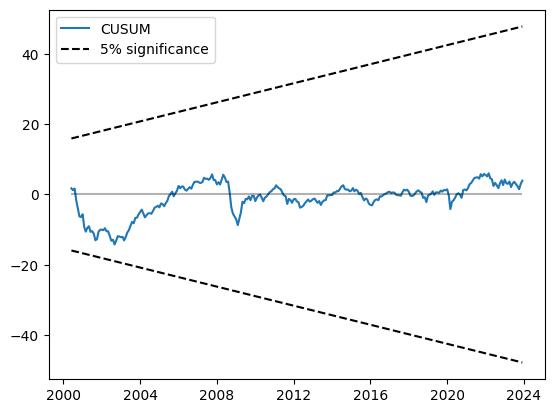

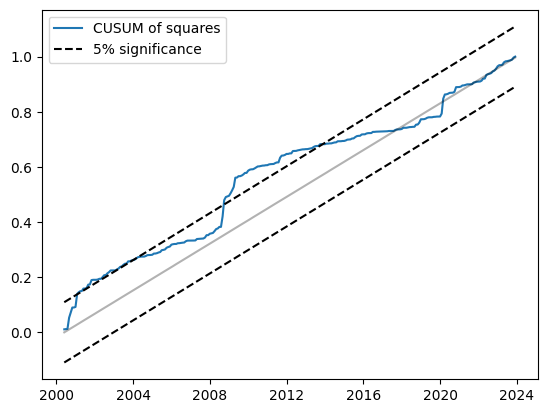

In [90]:
# Conduct parameter instability tests for the model above
simpleModelRecursive = rls.RecursiveLS(prices['monthlyReturn'], exogSimple).fit()

# Plotting CUSUM and CUSUM^2 graphs
cusumResults = simpleModelRecursive.plot_cusum(alpha=0.05, legend_loc='upper left')
cusumSquaredResults = simpleModelRecursive.plot_cusum_squares(alpha=0.05, legend_loc='upper left')

# It appears that according the CUSUM^2 graph, there is some parameter instability. I will test to verify this.

In [91]:
# Testing to verify parameter instability
# Break quarters appear to be from 2000-2008, 2009-2014, 2015-2023

# 2000-2008
pricesGroup1 = prices.iloc[:108]
exogPricesGroup1 = sm.add_constant(data=pricesGroup1[['effectPeriod']])
pricesGroup1Model = sm.OLS(pricesGroup1['monthlyReturn'], exogPricesGroup1).fit()


# 2009-2014
pricesGroup2 = prices.iloc[108:180]
exogPricesGroup2 = sm.add_constant(data=pricesGroup2[['effectPeriod']])
pricesGroup2Model = sm.OLS(pricesGroup2['monthlyReturn'], exogPricesGroup2).fit()

# 2015-2023
pricesGroup3 = prices.iloc[180:]
exogPricesGroup3 = sm.add_constant(data=pricesGroup3[['effectPeriod']])
pricesGroup3Model = sm.OLS(pricesGroup3['monthlyReturn'], exogPricesGroup3).fit()

# # Using Chow Tests to Determine if These Periods have statistically-significant parameter instability
k = 1

# # Compare 2000-2008 data vs 2009-2014 data
chowTest1Observations = pricesGroup1.shape[0] + pricesGroup2.shape[0]
chowTest1SecondDF = chowTest1Observations - 2 * k

# Obtain SSR for combined model
testGroup1 = prices.iloc[0:180]
exogTestGroup1 = sm.add_constant(data=testGroup1[['effectPeriod']])
testGroup1Model = sm.OLS(testGroup1['monthlyReturn'], exogTestGroup1).fit()

# # Calculating Chow Test in 2 Steps
chowTest1 = (testGroup1Model.ssr - (pricesGroup1Model.ssr + pricesGroup2Model.ssr)) / k
chowTest1 = chowTest1 / ((pricesGroup1Model.ssr + pricesGroup2Model.ssr)/ chowTest1Observations)

print("Result of the Chow Test (comparing 2000-2008 vs 2009-2014) is: " + str(chowTest1))

# Compare 2009-2014 data vs 2015-2023 data
chowTest2Observations = pricesGroup2.shape[0] + pricesGroup3.shape[0]
chowTest2SecondDF = chowTest2Observations - 2 * k

# Obtain SSR for combined model
testGroup2 = prices.iloc[108:]
exogTestGroup2 = sm.add_constant(data=testGroup2[['effectPeriod']])
testGroup2Model = sm.OLS(testGroup2['monthlyReturn'], exogTestGroup2).fit()

# Calculating Chow Test in 2 Steps
chowTest2 = (testGroup2Model.ssr - (pricesGroup2Model.ssr + pricesGroup3Model.ssr)) / (pricesGroup2Model.ssr + pricesGroup3Model.ssr)
chowTest2 = chowTest2 * (chowTest2SecondDF / k)

print("Result of the Chow Test (comparing 2009-2014 vs 2015-2023) is: " + str(chowTest2))

# Did not detect structural breaks at the 5% level, despite the CUSUM^2 results

Result of the Chow Test (comparing 2000-2008 vs 2009-2014) is: 0.8549516985937874
Result of the Chow Test (comparing 2009-2014 vs 2015-2023) is: 0.39689866027323767


In [92]:
# Test a some other ETFs to see if the halloween effect (with the simple regression model) still occurs in specific markets of the TSX
# Note the smaller sample size
for i in otherETFs:
    exogSimple = sm.add_constant(data=otherPrices[['effectPeriod']])
    simpleModel = sm.OLS(otherPrices[i], exogSimple).fit()
    print(simpleModel.summary())
    
    # Test for CLRM model assumptions

    # Test to See that residuals add up to zero
    print(simpleModel.resid.mean())

    # Test for to see if homoskedasticity assumption is violated
    # Set robust = False as I want to test that residuals are normally distributed (original Breush-Pagan)
    heteroskedasticityTest = dg.het_breuschpagan(simpleModel.resid, exogSimple, robust=False)

    print(heteroskedasticityTest)

    # Does not violate homoskedasticity assumption

    # # Test for autocorrelation (testing across effect period length of 6 months)
    autocorrelationTest = dg.acorr_breusch_godfrey(simpleModel, nlags=6)

    print(autocorrelationTest)
    # No statistically significant evidence of autocorrelation using last 6 months of data

                            OLS Regression Results                            
Dep. Variable:                 XIC.TO   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.723
Date:                Fri, 05 Apr 2024   Prob (F-statistic):              0.191
Time:                        22:27:50   Log-Likelihood:                -703.32
No. Observations:                 253   AIC:                             1411.
Df Residuals:                     251   BIC:                             1418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4299      0.349      1.232   

In [93]:
# Adding January Effect to the simple model
# We want to see if the January effect is being confounded with the Halloween Effect (since it is said that stocks go up more than usual in January)
# Want to see if the January Effect really causing the Halloween Effect.

januaryEffectExog = sm.add_constant(prices[['effectPeriodAdjusted', 'januaryEffect']])
januaryEffectModel = sm.OLS(prices['monthlyReturn'], januaryEffectExog)
januaryEffectModelResults = januaryEffectModel.fit()

print(januaryEffectModelResults.summary())

# Test for CLRM Model Assumptions
# Test to See that residuals add up to zero
print(januaryEffectModelResults.resid.mean())

# Test for to see if homoskedasticity assumption is violated
# Set robust = False as I want to test that residuals are normally distributed (original Breush-Pagan)
heteroskedasticityTest = dg.het_breuschpagan(januaryEffectModelResults.resid, januaryEffectExog, robust=False)

print(heteroskedasticityTest)

# Does not violate homoskedasticity assumption

# # Test for autocorrelation (testing across effect period length of 6 months)
autocorrelationTest = dg.acorr_breusch_godfrey(januaryEffectModelResults, nlags=6)

print(autocorrelationTest)
# No statistically significant evidence of autocorrelation using last 6 months of data

                            OLS Regression Results                            
Dep. Variable:          monthlyReturn   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.498
Date:                Fri, 05 Apr 2024   Prob (F-statistic):              0.225
Time:                        22:27:50   Log-Likelihood:                -811.87
No. Observations:                 288   AIC:                             1630.
Df Residuals:                     285   BIC:                             1641.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2153 

In [94]:
# Construct Strategy Returns, one for the standard buy and hold strategy and one for the Halloween Effect Strategy

# Buy and hold strategy already exists (monthly market returns) as a variable
# So I need to construct a Halloween Effect trading strategy variable
# This variable will hold stocks from November-April (inclusive) and hold the risk free treasury bills from May-October(inclusive)

halloweenStrategyMonthlyReturn = []

# Creating a new data frame that comparisons the standard buy and hold strategy with the halloween effect buying strategy
prices.reset_index(inplace=True)

for i in range(len(prices)):
    if prices.iloc[i]['date'].month > 4 and prices.iloc[i]['date'].month < 11:
        halloweenStrategyMonthlyReturn.append(prices.iloc[i]['monthlyRiskFreeRate'])
    else:
        halloweenStrategyMonthlyReturn.append(prices.iloc[i]['monthlyReturn'])
        
# Setting index to date so we can see it on the CUSUM graphs
prices.set_index('date', inplace=True)
        
# Adding Halloween Strategy returns
prices['halloweenStrategyReturn'] = halloweenStrategyMonthlyReturn 

# Constructing a variable that subtracts the risk free from the returns of the portfolio
prices['halloweenStrategyDifference'] = prices['halloweenStrategyReturn'] - prices['monthlyRiskFreeRate']

# Constructing a market risk premium variable
prices['halloweenStrategyRiskPremium'] = prices['monthlyReturn'] - prices['monthlyRiskFreeRate']

prices.head(8)

,monthlyReturn,effectPeriod,januaryEffect,effectPeriodAdjusted,monthlyRiskFreeRate,halloweenStrategyReturn,halloweenStrategyDifference,halloweenStrategyRiskPremium
date,,,,,,,,
2000-01-01,1.208480,1,1,0,0.445833,1.208480,0.762647,0.762647
2000-02-01,4.278614,1,0,1,0.445833,4.278614,3.832781,3.832781
2000-03-01,9.064881,1,0,1,0.452500,9.064881,8.612381,8.612381
2000-04-01,-1.603264,1,0,1,0.467500,-1.603264,-2.070764,-2.070764
2000-05-01,0.715572,0,0,0,0.494667,0.494667,0.000000,0.220906
2000-06-01,10.834780,0,0,0,0.484375,0.484375,0.000000,10.350405
2000-07-01,3.094705,0,0,0,0.479583,0.479583,0.000000,2.615122
2000-08-01,7.092701,0,0,0,0.479000,0.479000,0.000000,6.613701


In [95]:
# CAPM Model Evaluation

# Using variable constructed above, I will run create a CAPM model to evaluate the performance of the Halloween Strategy
# Want to see what the Alpha is, so I will add a constant to the CAPM model to represent an alpha value
exogCapmModel = sm.add_constant(prices['halloweenStrategyRiskPremium'])
capmModel = sm.OLS(prices['halloweenStrategyDifference'], exogCapmModel).fit()

# The constant is 0.2131, which is the alpha value

# Test for CLRM Model Assumptions
# Test to See that residuals add up to zero
print(capmModel.resid.mean())

# Test for to see if homoskedasticity assumption is violated
# Set robust = False as I want to test that residuals are normally distributed (original Breush-Pagan)
heteroskedasticityTest = dg.het_breuschpagan(capmModel.resid, exogCapmModel, robust=False)

print(heteroskedasticityTest)

# Homoskedasticity assumption is violated -- must re-compute test with robust standard errors

capmModel = sm.OLS(prices['halloweenStrategyDifference'], exogCapmModel).fit(cov_type="HC1")
print(capmModel.summary())

# # Test for autocorrelation (testing across effect period length of 6 months)
autocorrelationTest = dg.acorr_breusch_godfrey(capmModel, nlags=6)

print(autocorrelationTest)
# No statistically significant evidence of autocorrelation using last 6 months of data

-3.0839528461809902e-18
(39.03724132240836, 4.157976177482545e-10, 22.585505210171352, 3.1873848596675246e-06)
                                 OLS Regression Results                                
Dep. Variable:     halloweenStrategyDifference   R-squared:                       0.474
Model:                                     OLS   Adj. R-squared:                  0.472
Method:                          Least Squares   F-statistic:                     53.95
Date:                         Fri, 05 Apr 2024   Prob (F-statistic):           2.15e-12
Time:                                 22:27:50   Log-Likelihood:                -614.28
No. Observations:                          288   AIC:                             1233.
Df Residuals:                              286   BIC:                             1240.
Df Model:                                    1                                         
Covariance Type:                           HC1                                         
         

c:\Users\isss1\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


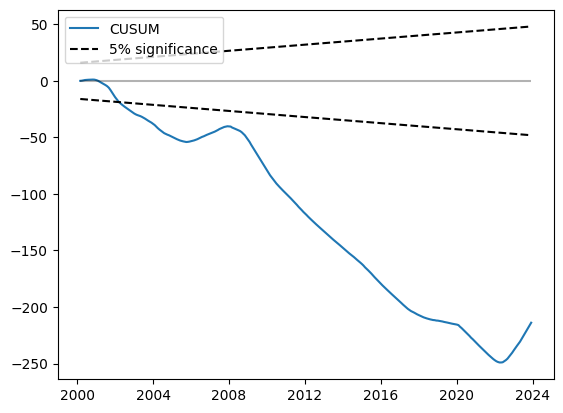

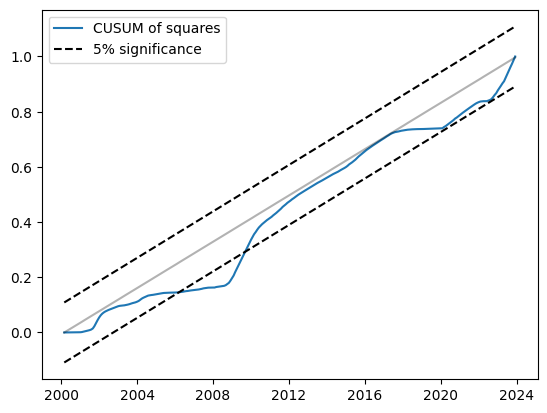

In [96]:
# Test CAPM Model for Parameter Instability

# Conduct parameter instability tests for the model above
capmModelRecursive = rls.RecursiveLS(prices['monthlyReturn'], exogCapmModel).fit()

# Plotting CUSUM and CUSUM^2 graphs
cusumResults = capmModelRecursive.plot_cusum(alpha=0.05, legend_loc='upper left')
cusumSquaredResults = capmModelRecursive.plot_cusum_squares(alpha=0.05, legend_loc='upper left')

# It appears that according the CUSUM^2 graph, there is some parameter instability.

In [97]:
# Evaluate for statistically significant parameter instabilty based on the CUSUM and CUSUM^2 graph

# Define Test Statistic Calculation
def computeChowTest(pricesGroup1Model, pricesGroup2Model, testGroupModel, chowTestObservations):
    chowTest = (testGroupModel.ssr - (pricesGroup1Model.ssr + pricesGroup2Model.ssr)) / k
    chowTest = chowTest / ((pricesGroup1Model.ssr + pricesGroup2Model.ssr)/ chowTestObservations)
    
    return chowTest


# From both of the CUSUM and CUSUM^2 tests we've identified the following break quarters
# 2000-2002, 2002-2006, 2007-2010, 2011-2024

# 2000-2002
pricesGroup1 = prices.iloc[:36]

exogCapmP1 = sm.add_constant(pricesGroup1['halloweenStrategyRiskPremium'])
capmModelP1 = sm.OLS(pricesGroup1['halloweenStrategyDifference'], exogCapmP1).fit()

# 2003-2006
pricesGroup2 = prices.iloc[36:84]
exogCapmP2 = sm.add_constant(pricesGroup2['halloweenStrategyRiskPremium'])
capmModelP2 = sm.OLS(pricesGroup2['halloweenStrategyDifference'], exogCapmP2).fit()

# 2007-2010
pricesGroup3 = prices.iloc[84:132]
exogCapmP3 = sm.add_constant(pricesGroup3['halloweenStrategyRiskPremium'])
capmModelP3 = sm.OLS(pricesGroup3['halloweenStrategyDifference'], exogCapmP3).fit()

# 2011-2024
pricesGroup4 = prices.iloc[132:]
exogCapmP4 = sm.add_constant(pricesGroup4['halloweenStrategyRiskPremium'])
capmModelP4 = sm.OLS(pricesGroup4['halloweenStrategyDifference'], exogCapmP4).fit()

# Compare 2000-2002 vs 2003-2006
chowTest1Observations = pricesGroup1.shape[0] + pricesGroup2.shape[0]
chowTest1SecondDF = chowTest1Observations - 2 * k

# Obtain SSR for combined model
testGroup1 = prices.iloc[0:84]
exogTestGroup1 = sm.add_constant(testGroup1['halloweenStrategyRiskPremium'])
testGroup1Model = sm.OLS(testGroup1['halloweenStrategyDifference'], exogTestGroup1).fit()

# Calculating Chow Test in 2 Steps
chowTest1 = computeChowTest(capmModelP1, capmModelP2, testGroup1Model, chowTest1Observations)

print("Result of the Chow Test (comparing 2000-2002 vs 2003-2006) is: " + str(chowTest1))

# Compare 2003-2006 vs 2007-2010
chowTest2Observations = pricesGroup3.shape[0] + pricesGroup4.shape[0]
chowTest2SecondDF = chowTest2Observations - 2 * k

# Obtain SSR for combined model
testGroup2 = prices.iloc[84:132]
exogTestGroup2 = sm.add_constant(testGroup2['halloweenStrategyRiskPremium'])
testGroup2Model = sm.OLS(testGroup2['halloweenStrategyDifference'], exogTestGroup2).fit()

# Calculating Chow Test in 2 Steps
chowTest = computeChowTest(capmModelP2, capmModelP3, testGroup2Model, chowTest2Observations)

print("Result of the Chow Test (comparing 2003-2006 vs 2007-2010) is: " + str(chowTest2))

# Compare 2007-2010 vs 2011-2024
chowTest3Observations = pricesGroup3.shape[0] + pricesGroup4.shape[0]
chowTest3SecondDF = chowTest3Observations - 2 * k

# Obtain SSR for combined model
testGroup3 = prices.iloc[84:]
exogTestGroup3 = sm.add_constant(testGroup3['halloweenStrategyRiskPremium'])
testGroup3Model = sm.OLS(testGroup3['halloweenStrategyDifference'], exogTestGroup3).fit()

# Calculating Chow Test in 2 Steps
chowTest3 = computeChowTest(capmModelP3, capmModelP4, testGroup3Model, chowTest3Observations)

print("Result of the Chow Test (comparing 2007-2010 vs 2011-2024) is: " + str(chowTest3))

# Found one structural break between 2010 and 2011
# Estimating the two different models with the data
pricesCapm1 = prices[:132]
pricesCapm2 = prices[132:]

# 2000-2010
exogCapm1 = sm.add_constant(pricesCapm1['halloweenStrategyRiskPremium'])
capmModel1 = sm.OLS(pricesCapm1['halloweenStrategyDifference'], exogCapm1).fit(cov_type="HC1")

print(capmModel1.summary())

# 2011 - 2024
exogCapm2 = sm.add_constant(pricesCapm2['halloweenStrategyRiskPremium'])
capmModel2 = sm.OLS(pricesCapm2['halloweenStrategyDifference'], exogCapm2).fit(cov_type="HC1")

print(capmModel2.summary())

Result of the Chow Test (comparing 2000-2002 vs 2003-2006) is: 1.5010101178234885
Result of the Chow Test (comparing 2003-2006 vs 2007-2010) is: 0.39689866027323767
Result of the Chow Test (comparing 2007-2010 vs 2011-2024) is: 10.075047779934657
                                 OLS Regression Results                                
Dep. Variable:     halloweenStrategyDifference   R-squared:                       0.417
Model:                                     OLS   Adj. R-squared:                  0.413
Method:                          Least Squares   F-statistic:                     23.76
Date:                         Fri, 05 Apr 2024   Prob (F-statistic):           3.13e-06
Time:                                 22:27:51   Log-Likelihood:                -298.52
No. Observations:                          132   AIC:                             601.0
Df Residuals:                              130   BIC:                             606.8
Df Model:                                    1   